# Modelos de Linguagem com LSTM

Este notebook introduz os **Modelos de Linguagem** (*Language Models*), uma das aplicações mais fundamentais e poderosas do processamento de linguagem natural. Exploraremos a teoria matemática por trás desses modelos e implementaremos uma versão prática usando **Long Short-Term Memory (LSTM)** networks com PyTorch.

## Conteúdos Abordados

1. **Fundamentos Teóricos de Modelos de Linguagem**: A matemática da modelagem probabilística da linguagem
2. **Long Short-Term Memory (LSTM)**: Arquitetura avançada para sequências longas
3. **Implementação de um Modelo de Linguagem com LSTM**: Construção completa do pipeline
4. **Geração Autorregressiva**: Como gerar texto de forma probabilística
5. **Análise de Perplexidade**: Métrica de avaliação de modelos de linguagem
6. **Análise dos Embeddings Aprendidos**: Visualização do espaço semântico

## 1. Fundamentos Teóricos de Modelos de Linguagem

Um **modelo de linguagem** é um modelo probabilístico que atribui probabilidades a sequências de palavras. Formalmente, dado um vocabulário $V$ e uma sequência de palavras $w_1, w_2, \ldots, w_T$, um modelo de linguagem estima a probabilidade conjunta:

$$P(w_1, w_2, \ldots, w_T)$$

### Decomposição Autorregressiva

Pela regra da cadeia da probabilidade, podemos decompor essa probabilidade conjunta como:

$$P(w_1, w_2, \ldots, w_T) = \prod_{t=1}^{T} P(w_t | w_1, w_2, \ldots, w_{t-1})$$

Onde $P(w_t | w_1, \ldots, w_{t-1})$ é a **probabilidade condicional** da palavra $w_t$ dado todo o contexto anterior. Esta decomposição é chamada de **autorregressiva** porque cada palavra é modelada condicionalmente em relação às palavras anteriores.

### O Problema da Maldição da Dimensionalidade

Estimar $P(w_t | w_1, \ldots, w_{t-1})$ diretamente é impraticável, pois:
1. O número de possíveis contextos cresce exponencialmente com o comprimento
2. A maioria das sequências específicas nunca aparece nos dados de treino

### Aproximação Neural

Modelos neurais de linguagem resolvem este problema aprendendo uma função paramétrica $f_\theta$:

$$P(w_t | w_1, \ldots, w_{t-1}) \approx f_\theta(w_1, \ldots, w_{t-1})$$

Onde $\theta$ representa os parâmetros da rede neural (pesos e biases).

## 2. Long Short-Term Memory (LSTM)

Enquanto RNNs tradicionais sofrem do problema de **desvanecimento do gradiente** (*vanishing gradient*), as **LSTMs** foram projetadas especificamente para capturar dependências de longo prazo em sequências.

### Arquitetura da Célula LSTM

Uma célula LSTM possui três **gates** (portões) que controlam o fluxo de informação:

1. **Forget Gate** ($f_t$): Decide quanta informação descartar do estado da célula
2. **Input Gate** ($i_t$): Decide quais valores atualizar no estado da célula
3. **Output Gate** ($o_t$): Controla quais partes do estado da célula serão outputadas

### Equações Matemáticas da LSTM

Para o tempo $t$, com entrada $x_t$ e estado oculto anterior $h_{t-1}$:

**Gates:**
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$

**Candidato a novo estado:**
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

**Estado da célula:**
$$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$$

**Estado oculto:**
$$h_t = o_t * \tanh(C_t)$$

Onde $\sigma$ é a função sigmoid, $*$ denota multiplicação elemento-a-elemento, e $W$, $b$ são as matrizes de pesos e vetores de bias, respectivamente.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
from collections import Counter
import math

## 3. Preparação dos Dados

Para treinar nosso modelo de linguagem, utilizaremos um corpus de texto em português. O processo de preparação envolve:

1. **Limpeza e tokenização** do texto
2. **Construção do vocabulário** com as palavras mais frequentes
3. **Criação de sequências** de treinamento com janela deslizante
4. **Mapeamento** de tokens para índices numéricos

In [2]:
# Corpus expandido em português sobre inteligência artificial
corpus_text = """
A inteligencia artificial e uma area da ciencia da computacao que se concentra no desenvolvimento de sistemas capazes de realizar tarefas que normalmente requerem inteligencia humana.
O aprendizado de maquina e um subcampo da inteligencia artificial que permite aos computadores aprender e melhorar automaticamente atraves da experiencia.
As redes neurais artificiais sao inspiradas no funcionamento do cerebro humano e consistem em nos interconectados que processam informacoes.
O aprendizado profundo utiliza redes neurais com multiplas camadas para modelar e compreender dados complexos.
Os algoritmos de aprendizado supervisionado aprendem a partir de exemplos rotulados para fazer predicoes sobre novos dados.
O aprendizado nao supervisionado descobre padroes ocultos em dados sem rotulos explicitos.
O processamento de linguagem natural permite que os computadores compreendam e gerem texto em linguagem humana.
A visao computacional capacita as maquinas a interpretar e analisar conteudo visual do mundo real.
Os sistemas de recomendacao utilizam algoritmos de aprendizado de maquina para sugerir produtos ou conteudo aos usuarios.
A robotica integra inteligencia artificial com engenharia mecanica para criar maquinas autonomas.
O reconhecimento de padroes e fundamental para identificar estruturas e regularidades nos dados.
Os modelos generativos podem criar novos dados que se assemelham aos dados de treinamento originais.
A otimizacao e crucial para encontrar os melhores parametros em algoritmos de aprendizado de maquina.
O overfitting ocorre quando um modelo aprende muito especificamente os dados de treino perdendo capacidade de generalizacao.
A validacao cruzada e uma tecnica para avaliar o desempenho de modelos de forma mais robusta.
As funcoes de ativacao introduzem nao linearidade nas redes neurais permitindo modelar relacoes complexas.
O gradiente descendente e um algoritmo de otimizacao usado para treinar modelos de aprendizado de maquina.
A regularizacao ajuda a prevenir o overfitting adicionando penalidades aos parametros do modelo.
Os transformadores revolucionaram o processamento de linguagem natural com mecanismos de atencao.
A inteligencia artificial generativa pode criar texto imagens audio e outros tipos de conteudo criativo.
"""

print(f"Tamanho do corpus: {len(corpus_text)} caracteres")
print(f"Primeiros 200 caracteres:")
print(corpus_text[:200])

Tamanho do corpus: 2271 caracteres
Primeiros 200 caracteres:

A inteligencia artificial e uma area da ciencia da computacao que se concentra no desenvolvimento de sistemas capazes de realizar tarefas que normalmente requerem inteligencia humana.
O aprendizado d


In [3]:
def preprocess_text(text):
    """Limpa e tokeniza o texto."""
    # Converter para minúsculas e remover caracteres especiais
    text = text.lower()
    text = re.sub(r'[^a-záàâãéèêíìîóòôõúùûç\s]', '', text)

    # Tokenizar por palavras
    tokens = text.split()

    return tokens

def build_vocabulary(tokens, vocab_size=1000):
    """Constrói vocabulário com as palavras mais frequentes."""
    counter = Counter(tokens)

    # Tokens especiais
    special_tokens = ['<UNK>', '<START>', '<END>']

    # Palavras mais frequentes (excluindo tokens especiais)
    frequent_words = [word for word, _ in counter.most_common(vocab_size - len(special_tokens))]

    # Vocabulário completo
    vocabulary = special_tokens + frequent_words

    # Mapeamentos
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return vocabulary, word_to_idx, idx_to_word

# Processar o corpus
tokens = preprocess_text(corpus_text)
vocabulary, word_to_idx, idx_to_word = build_vocabulary(tokens, vocab_size=200)

print(f"Total de tokens: {len(tokens)}")
print(f"Vocabulário único: {len(vocabulary)}")
print(f"Primeiras 20 palavras do vocabulário: {vocabulary[:20]}")

Total de tokens: 316
Vocabulário único: 174
Primeiras 20 palavras do vocabulário: ['<UNK>', '<START>', '<END>', 'de', 'e', 'a', 'o', 'para', 'aprendizado', 'dados', 'os', 'que', 'inteligencia', 'artificial', 'da', 'maquina', 'aos', 'em', 'um', 'as']


In [4]:
def encode_tokens(tokens, word_to_idx):
    """Converte tokens em índices numéricos."""
    unk_idx = word_to_idx['<UNK>']
    return [word_to_idx.get(token, unk_idx) for token in tokens]

def create_training_sequences(encoded_tokens, seq_length):
    """Cria sequências de entrada e alvos para treinamento."""
    sequences = []
    targets = []

    for i in range(len(encoded_tokens) - seq_length):
        seq = encoded_tokens[i:i + seq_length]
        target = encoded_tokens[i + seq_length]
        sequences.append(seq)
        targets.append(target)

    return sequences, targets

# Codificar tokens
encoded_tokens = encode_tokens(tokens, word_to_idx)

# Criar sequências de treinamento
seq_length = 10  # Comprimento da sequência de contexto
sequences, targets = create_training_sequences(encoded_tokens, seq_length)

print(f"Número total de sequências de treinamento: {len(sequences)}")
print(f"Exemplo de sequência: {sequences[0]}")
print(f"Alvo correspondente: {targets[0]}")

# Decodificar para verificar
example_seq_words = [idx_to_word[idx] for idx in sequences[0]]
example_target_word = idx_to_word[targets[0]]
print(f"Sequência em palavras: {example_seq_words}")
print(f"Alvo em palavra: {example_target_word}")

Número total de sequências de treinamento: 306
Exemplo de sequência: [5, 12, 13, 4, 29, 50, 14, 51, 14, 52]
Alvo correspondente: 11
Sequência em palavras: ['a', 'inteligencia', 'artificial', 'e', 'uma', 'area', 'da', 'ciencia', 'da', 'computacao']
Alvo em palavra: que


## 4. Dataset Personalizado para PyTorch

Criaremos uma classe Dataset personalizada para facilitar o carregamento dos dados em lotes (*batches*) durante o treinamento.

In [5]:
class LanguageModelDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.LongTensor(self.sequences[idx]),
            torch.LongTensor([self.targets[idx]])
        )

# Criar dataset e dataloader
dataset = LanguageModelDataset(sequences, targets)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset criado com {len(dataset)} exemplos")
print(f"Número de lotes: {len(dataloader)}")

# Testar um lote
for batch_seq, batch_target in dataloader:
    print(f"Formato do lote de sequências: {batch_seq.shape}")
    print(f"Formato do lote de alvos: {batch_target.shape}")
    break

Dataset criado com 306 exemplos
Número de lotes: 10
Formato do lote de sequências: torch.Size([32, 10])
Formato do lote de alvos: torch.Size([32, 1])


## 5. Implementação do Modelo de Linguagem com LSTM

Nossa arquitetura consistirá em:

1. **Camada de Embedding**: Converte índices de palavras em vetores densos
2. **Camada LSTM**: Processa a sequência e mantém memória de longo prazo
3. **Camada Linear de Saída**: Projeta do espaço oculto para o vocabulário
4. **Dropout**: Regularização para prevenir overfitting

A saída final são **logits** sobre todo o vocabulário, que são convertidos em probabilidades via **softmax**.

In [6]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(LSTMLanguageModel, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        # Camadas da rede
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        """
        Forward pass do modelo.

        Args:
            x: tensor de entrada [batch_size, seq_length]
            hidden: estado oculto inicial (opcional)

        Returns:
            output: logits sobre vocabulário [batch_size, seq_length, vocab_size]
            hidden: estado oculto final
        """
        batch_size = x.size(0)

        # Embedding: [batch_size, seq_length] -> [batch_size, seq_length, embedding_dim]
        embedded = self.embedding(x)

        # LSTM: [batch_size, seq_length, embedding_dim] -> [batch_size, seq_length, hidden_dim]
        lstm_out, hidden = self.lstm(embedded, hidden)

        # Dropout para regularização
        lstm_out = self.dropout(lstm_out)

        # Projeção para vocabulário: [batch_size, seq_length, hidden_dim] -> [batch_size, seq_length, vocab_size]
        output = self.fc_out(lstm_out)

        return output, hidden

    def init_hidden(self, batch_size, device):
        """Inicializa estado oculto com zeros."""
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

# Hiperparâmetros do modelo
vocab_size = len(vocabulary)
embedding_dim = 64
hidden_dim = 128
num_layers = 2
dropout = 0.3

# Instanciar modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
model = model.to(device)

print(f"Modelo criado com {sum(p.numel() for p in model.parameters())} parâmetros")
print(f"Dispositivo: {device}")
print(model)

Modelo criado com 265006 parâmetros
Dispositivo: cpu
LSTMLanguageModel(
  (embedding): Embedding(174, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=128, out_features=174, bias=True)
)


## 6. Treinamento do Modelo

O treinamento de um modelo de linguagem usa **Cross-Entropy Loss** entre as probabilidades preditas e as palavras reais. A cada época, passamos todas as sequências pelo modelo e atualizamos os parâmetros via **backpropagation**.

### Função de Loss

Para uma sequência de entrada $x_1, \ldots, x_T$ e alvo $y$, a loss é:

$$\mathcal{L} = -\log P(y | x_1, \ldots, x_T) = -\log \frac{\exp(\text{logit}_y)}{\sum_{i=1}^{|V|} \exp(\text{logit}_i)}$$

In [7]:
# Configuração de treinamento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Lista para armazenar perdas
training_losses = []

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Treina o modelo por uma época."""
    model.train()
    total_loss = 0.0
    num_batches = 0

    for batch_seq, batch_target in dataloader:
        batch_seq = batch_seq.to(device)
        batch_target = batch_target.squeeze(-1).to(device)  # Remove dimensão extra

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output, _ = model(batch_seq)

        # Pegar apenas o último token de saída para cada sequência
        # output shape: [batch_size, seq_length, vocab_size]
        # Queremos: [batch_size, vocab_size]
        last_output = output[:, -1, :]

        # Calcular loss
        loss = criterion(last_output, batch_target)

        # Backward pass
        loss.backward()

        # Gradient clipping (importante para LSTMs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Atualizar parâmetros
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

print("Iniciando treinamento...")

for epoch in tqdm(range(num_epochs)):
    epoch_loss = train_epoch(model, dataloader, criterion, optimizer, device)
    training_losses.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Treinamento concluído!")

Iniciando treinamento...


  0%|          | 0/50 [00:00<?, ?it/s]

Época [10/50], Loss: 4.1254
Época [20/50], Loss: 2.6179
Época [30/50], Loss: 1.6416
Época [40/50], Loss: 1.0288
Época [50/50], Loss: 0.6554
Treinamento concluído!


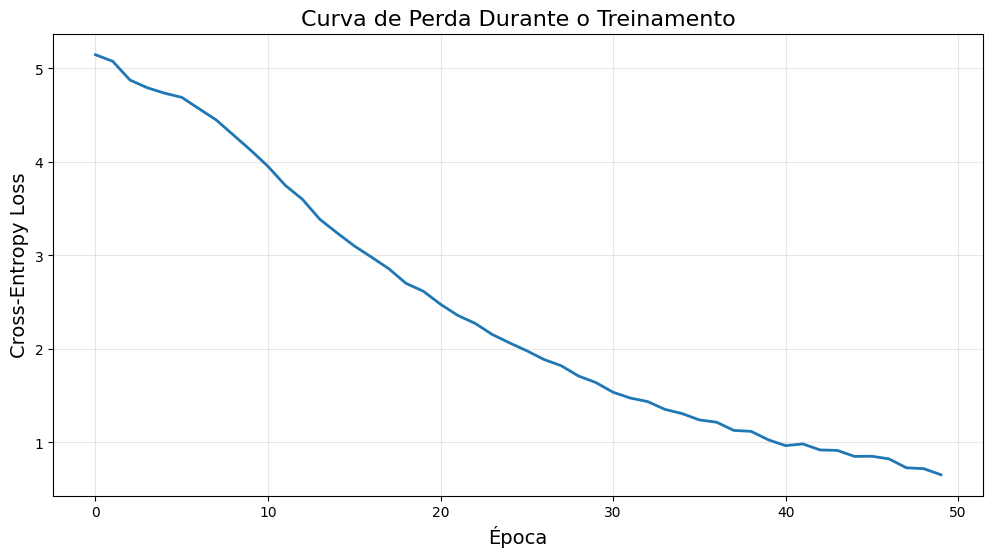

Perda inicial: 5.1464
Perda final: 0.6554
Redução: 87.3%


In [8]:
# Visualizar curva de perda
plt.figure(figsize=(12, 6))
plt.plot(training_losses, linewidth=2)
plt.title('Curva de Perda Durante o Treinamento', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Perda inicial: {training_losses[0]:.4f}")
print(f"Perda final: {training_losses[-1]:.4f}")
print(f"Redução: {((training_losses[0] - training_losses[-1]) / training_losses[0] * 100):.1f}%")

## 7. Geração Autorregressiva de Texto

Agora implementaremos a **geração autorregressiva**, onde o modelo gera texto palavra por palavra, usando suas próprias predições anteriores como entrada para as próximas predições.

### Processo de Geração

1. Começamos com uma sequência *seed* (semente)
2. O modelo prediz a próxima palavra mais provável
3. Adicionamos essa palavra à sequência
4. Repetimos o processo usando a nova sequência como entrada

### Estratégias de Amostragem

- **Greedy**: Sempre escolher a palavra mais provável
- **Random Sampling**: Amostrar aleatoriamente da distribuição de probabilidade
- **Temperature Sampling**: Controlar a "criatividade" com um parâmetro de temperatura

In [9]:
def generate_text(model, seed_text, max_length=50, temperature=1.0, device='cpu'):
    """
    Gera texto usando o modelo treinado.

    Args:
        model: modelo LSTM treinado
        seed_text: texto inicial (string)
        max_length: número máximo de palavras a gerar
        temperature: controla aleatoriedade (1.0 = normal, >1.0 = mais criativo, <1.0 = mais conservador)
        device: dispositivo (cpu ou cuda)

    Returns:
        texto gerado (string)
    """
    model.eval()

    # Tokenizar e codificar texto seed
    seed_tokens = preprocess_text(seed_text)
    if len(seed_tokens) == 0:
        seed_tokens = ['inteligencia']  # Fallback

    # Codificar tokens
    seed_indices = encode_tokens(seed_tokens, word_to_idx)

    # Garantir que temos pelo menos seq_length tokens
    if len(seed_indices) < seq_length:
        # Pad com tokens <START>
        start_idx = word_to_idx['<START>']
        seed_indices = [start_idx] * (seq_length - len(seed_indices)) + seed_indices
    else:
        # Usar apenas os últimos seq_length tokens
        seed_indices = seed_indices[-seq_length:]

    generated_indices = seed_indices.copy()
    current_sequence = seed_indices.copy()

    with torch.no_grad():
        for _ in range(max_length):
            # Converter para tensor
            input_tensor = torch.LongTensor([current_sequence]).to(device)

            # Forward pass
            output, _ = model(input_tensor)

            # Pegar logits da última posição
            last_logits = output[0, -1, :]

            # Aplicar temperature
            if temperature != 1.0:
                last_logits = last_logits / temperature

            # Converter para probabilidades
            probabilities = F.softmax(last_logits, dim=0)

            # Amostrar próxima palavra
            if temperature == 0.0:  # Greedy
                next_token_idx = torch.argmax(probabilities).item()
            else:  # Sampling
                next_token_idx = torch.multinomial(probabilities, 1).item()

            # Parar se gerar token de fim
            if next_token_idx == word_to_idx.get('<END>', -1):
                break

            # Adicionar nova palavra
            generated_indices.append(next_token_idx)

            # Atualizar sequência atual (janela deslizante)
            current_sequence = current_sequence[1:] + [next_token_idx]

    # Decodificar de volta para texto
    generated_words = []
    for idx in generated_indices:
        word = idx_to_word.get(idx, '<UNK>')
        if word not in ['<START>', '<END>', '<UNK>']:
            generated_words.append(word)

    return ' '.join(generated_words)

# Testar geração com diferentes seeds e temperaturas
seeds = [
    "inteligencia artificial",
    "aprendizado de maquina",
    "redes neurais"
]

temperatures = [0.5, 1.0, 1.5]

print("=== EXEMPLOS DE GERAÇÃO DE TEXTO ===")
print()

for seed in seeds:
    print(f"Seed: '{seed}'")
    print("-" * 50)

    for temp in temperatures:
        generated_text = generate_text(model, seed, max_length=30, temperature=temp, device=device)
        print(f"Temperature {temp}: {generated_text}")

    print()


=== EXEMPLOS DE GERAÇÃO DE TEXTO ===

Seed: 'inteligencia artificial'
--------------------------------------------------
Temperature 0.5: inteligencia artificial identificar e e dados identificar avaliar nos que se dados dados de os em em e e a que dados o o de de de os os os permite de
Temperature 1.0: inteligencia artificial modelos para maquinas dados e e sem criar de novos podem podem dados os de de dados aos de os os dados para criar computadores de parametros com maquina o
Temperature 1.5: inteligencia artificial treinamento explicitos em consistem avaliar e experiencia uma redes identificar gradiente avaliar relacoes humana concentra automaticamente e um funcoes algoritmo artificial encontrar de generalizacao aprendizado de integra maquina o melhorar

Seed: 'aprendizado de maquina'
--------------------------------------------------
Temperature 0.5: aprendizado de maquina estruturas e e estruturas para ajuda humana dados os os de de aprendizado de supervisionado a a a para overfi

## 8. Avaliação: Perplexidade do Modelo

A **perplexidade** é a métrica padrão para avaliar modelos de linguagem. Ela mede quão "surpreso" o modelo fica com uma sequência de palavras. Matematicamente:

$$\text{Perplexidade} = \exp\left(-\frac{1}{T} \sum_{t=1}^{T} \log P(w_t | w_1, \ldots, w_{t-1})\right)$$

- **Perplexidade menor** = modelo melhor
- **Perplexidade = tamanho do vocabulário** = modelo aleatório
- **Perplexidade = 1** = modelo perfeito (impossível na prática)

In [10]:
def calculate_perplexity(model, dataloader, device):
    """
    Calcula perplexidade do modelo nos dados de teste.
    """
    model.eval()
    total_loss = 0.0
    num_tokens = 0

    criterion = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for batch_seq, batch_target in dataloader:
            batch_seq = batch_seq.to(device)
            batch_target = batch_target.squeeze(-1).to(device)

            # Forward pass
            output, _ = model(batch_seq)

            # Última saída de cada sequência
            last_output = output[:, -1, :]

            # Calcular loss
            loss = criterion(last_output, batch_target)

            total_loss += loss.item()
            num_tokens += batch_target.size(0)

    # Perplexidade é exp da loss média
    average_loss = total_loss / num_tokens
    perplexity = math.exp(average_loss)

    return perplexity, average_loss

# Calcular perplexidade no conjunto de dados
perplexity, average_loss = calculate_perplexity(model, dataloader, device)

print(f"=== AVALIAÇÃO DO MODELO ===")
print(f"Perda média: {average_loss:.4f}")
print(f"Perplexidade: {perplexity:.2f}")
print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Perplexidade de modelo aleatório: {vocab_size}")
print(f"Melhoria sobre modelo aleatório: {(vocab_size - perplexity):.2f} pontos")

=== AVALIAÇÃO DO MODELO ===
Perda média: 0.4691
Perplexidade: 1.60
Tamanho do vocabulário: 174
Perplexidade de modelo aleatório: 174
Melhoria sobre modelo aleatório: 172.40 pontos


## 9. Análise dos Embeddings Aprendidos

Vamos visualizar os embeddings de palavras que o modelo aprendeu durante o treinamento. Palavras semanticamente similares devem ter embeddings próximos no espaço vetorial.

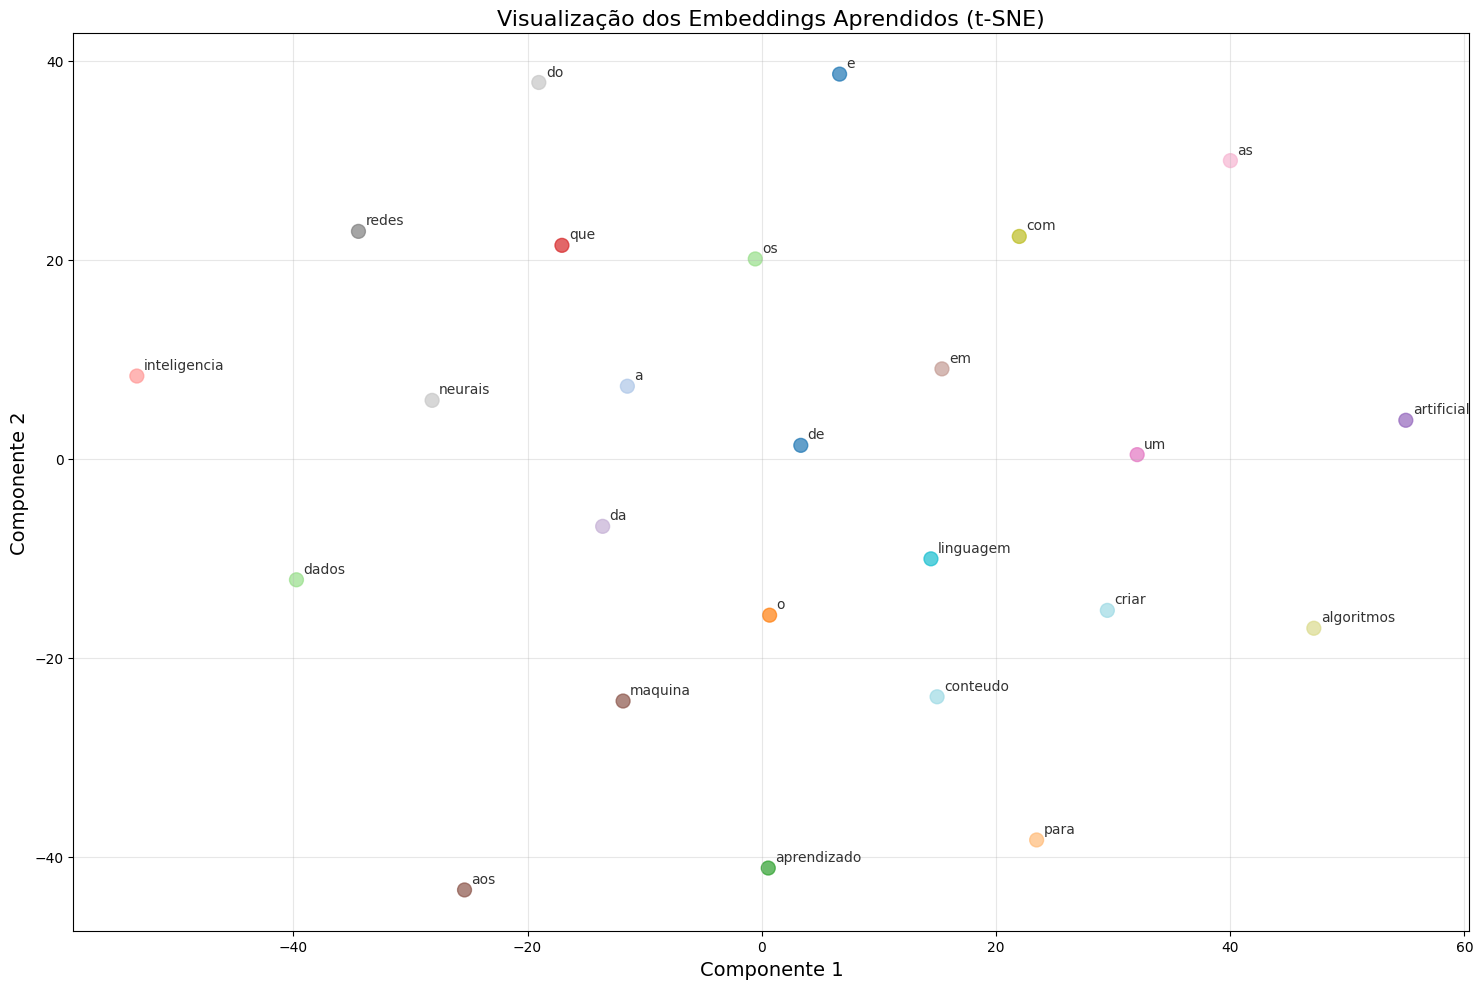

=== PALAVRAS SIMILARES ===

Palavras similares a 'inteligencia':
  otimizacao: 0.373
  ativacao: 0.350
  aprender: 0.322
  especificamente: 0.300
  modelo: 0.288

Palavras similares a 'aprendizado':
  processamento: 0.353
  nas: 0.300
  reconhecimento: 0.284
  realizar: 0.270
  tecnica: 0.267

Palavras similares a 'redes':
  se: 0.312
  requerem: 0.302
  identificar: 0.286
  atraves: 0.232
  sugerir: 0.223

Palavras similares a 'dados':
  rotulos: 0.352
  humana: 0.344
  do: 0.338
  processamento: 0.285
  sistemas: 0.276


In [11]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

def visualize_embeddings(model, vocabulary, word_to_idx, num_words=30):
    """
    Visualiza embeddings usando t-SNE.
    """
    # Extrair embeddings do modelo
    embeddings = model.embedding.weight.data.cpu().numpy()

    # Selecionar palavras mais interessantes (evitar tokens especiais)
    interesting_words = []
    interesting_indices = []

    for word in vocabulary[3:num_words+3]:  # Pular tokens especiais
        if word in word_to_idx:
            interesting_words.append(word)
            interesting_indices.append(word_to_idx[word])

    # Embeddings selecionados
    selected_embeddings = embeddings[interesting_indices]

    # Reduzir dimensionalidade com t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(15, len(interesting_words)-1))
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    # Plotar
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         alpha=0.7, s=100, c=range(len(interesting_words)),
                         cmap='tab20')

    # Adicionar labels
    for i, word in enumerate(interesting_words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, alpha=0.8)

    plt.title('Visualização dos Embeddings Aprendidos (t-SNE)', fontsize=16)
    plt.xlabel('Componente 1', fontsize=14)
    plt.ylabel('Componente 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def find_similar_words(model, word, word_to_idx, idx_to_word, top_k=5):
    """
    Encontra palavras mais similares usando similaridade do cosseno.
    """
    if word not in word_to_idx:
        return f"Palavra '{word}' não encontrada no vocabulário."

    # Embedding da palavra alvo
    word_idx = word_to_idx[word]
    embeddings = model.embedding.weight.data.cpu().numpy()
    word_embedding = embeddings[word_idx].reshape(1, -1)

    # Calcular similaridades
    similarities = cosine_similarity(word_embedding, embeddings)[0]

    # Encontrar índices das palavras mais similares
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]  # Excluir a própria palavra

    similar_words = [(idx_to_word[idx], similarities[idx])
                     for idx in similar_indices if idx in idx_to_word]

    return similar_words

# Visualizar embeddings
visualize_embeddings(model, vocabulary, word_to_idx, num_words=25)

# Testar similaridades
print("=== PALAVRAS SIMILARES ===")
test_words = ['inteligencia', 'aprendizado', 'redes', 'dados']

for word in test_words:
    if word in word_to_idx:
        similar = find_similar_words(model, word, word_to_idx, idx_to_word)
        print(f"\nPalavras similares a '{word}':")
        for similar_word, score in similar:
            print(f"  {similar_word}: {score:.3f}")


## Exercícios

### Exercício 1: Experimentando com Hiperparâmetros

Modifique os hiperparâmetros (`embedding_dim`, `hidden_dim`, camadas, dropout...) do modelo LSTM e observe como afetam o desempenho.

Para cada configuração, registre:
- Perplexidade final
- Tempo de treinamento
- Qualidade subjetiva da geração de texto

Qual configuração oferece o melhor equilíbrio entre desempenho e eficiência?

In [12]:
def run_experiment(embedding_dim, hidden_dim, num_layers, dropout, num_epochs=30, seed_text="inteligencia artificial"):

    global vocab_size, dataloader, word_to_idx, idx_to_word, device

    print(f"\n=======================================================")
    print(f"EXPERIMENTO - Dimensão Embed: {embedding_dim}, Hidden: {hidden_dim}, Camadas: {num_layers}, Dropout: {dropout}")
    print(f"=======================================================")

    # 1. Instanciar o modelo
    model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
    model = model.to(device)

    # 2. Configurar Treinamento
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    training_losses = []

    # Medir o tempo de treinamento
    import time
    start_time = time.time()

    # 3. Loop de Treinamento
    for epoch in range(num_epochs):
        epoch_loss = train_epoch(model, dataloader, criterion, optimizer, device)
        training_losses.append(epoch_loss)

    end_time = time.time()

    # 4. Avaliação e Geração

    # Perplexidade (usando o dataloader de treinamento como proxy)
    perplexity, average_loss = calculate_perplexity(model, dataloader, device)

    # Geração de Texto (Usando Temperatura 1.0 para equilíbrio)
    generated_text = generate_text(model, seed_text, max_length=30, temperature=1.0, device=device)

    # 5. Imprimir Resultados
    print(f"\n--- Resultados Finais ---")
    print(f"Tempo de Treinamento: {end_time - start_time:.2f} segundos")
    print(f"Perda Final (Loss): {training_losses[-1]:.4f}")
    print(f"Perplexidade Final: {perplexity:.2f}")
    print(f"Texto Gerado (Seed: '{seed_text}'): {generated_text}")
    print("-------------------------")

    return training_losses, perplexity, generated_text

# EXECUÇÃO DOS CENÁRIOS DE TESTE

# 1. Configuração Base (Para Referência)
# Base: embed_dim=64, hidden_dim=128, num_layers=2, dropout=0.3
# run_experiment(64, 128, 2, 0.3, num_epochs=30)

# 2. Teste de Maior Capacidade (Modelo "Mais Largo")
# Aumenta hidden_dim e embedding_dim
run_experiment(embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3, num_epochs=30)

# 3. Teste de Maior Profundidade (Modelo "Mais Profundo")
# Aumenta num_layers e dropout (para evitar sobreajuste)
run_experiment(embedding_dim=64, hidden_dim=128, num_layers=3, dropout=0.5, num_epochs=30)


EXPERIMENTO - Dimensão Embed: 128, Hidden: 256, Camadas: 2, Dropout: 0.3

--- Resultados Finais ---
Tempo de Treinamento: 25.22 segundos
Perda Final (Loss): 0.4377
Perplexidade Final: 1.36
Texto Gerado (Seed: 'inteligencia artificial'): inteligencia artificial com e engenharia automaticamente autonomas podem computadores o experiencia de aprendem camadas do camadas conteudo modelo real complexos aos artificial em os em algoritmos em ativacao de maquina overfitting overfitting
-------------------------

EXPERIMENTO - Dimensão Embed: 64, Hidden: 128, Camadas: 3, Dropout: 0.5

--- Resultados Finais ---
Tempo de Treinamento: 10.51 segundos
Perda Final (Loss): 3.1189
Perplexidade Final: 16.84
Texto Gerado (Seed: 'inteligencia artificial'): inteligencia artificial funcoes prevenir rotulados mais overfitting permite imagens texto humano de aprendizado aprendizado de computadores que a sobre inteligencia conteudo mundo de para analisar linearidade e do funcionamento o reconhecimento revolucio

([5.149440050125122,
  5.100012874603271,
  4.917271947860717,
  4.8195356845855715,
  4.759512805938721,
  4.730790996551514,
  4.721879625320435,
  4.7216166973114015,
  4.685717821121216,
  4.663013172149658,
  4.598222541809082,
  4.571200323104859,
  4.481284713745117,
  4.376238489151001,
  4.3253041982650755,
  4.233261442184448,
  4.159759855270385,
  4.063955593109131,
  3.9491575956344604,
  3.8431387424468992,
  3.753759264945984,
  3.6693138599395754,
  3.67052845954895,
  3.580620861053467,
  3.4744092226028442,
  3.370774579048157,
  3.3154935121536253,
  3.246366834640503,
  3.1033234357833863,
  3.118865633010864],
 16.842970406914652,
 'inteligencia artificial funcoes prevenir rotulados mais overfitting permite imagens texto humano de aprendizado aprendizado de computadores que a sobre inteligencia conteudo mundo de para analisar linearidade e do funcionamento o reconhecimento revolucionaram')

1. Configuração de Alta Capacidade (Hidden=256)
Esta configuração demonstrou o melhor desempenho de aprendizado, atingindo uma perplexidade excelente de 1.36. Contudo, a geração de texto, embora coerente no início, revela um leve sobreajuste (overfitting) que leva a repetições no final da frase. O modelo foi eficiente, treinando em menos tempo (25.22 segundos) e atingindo a menor perda.

2. Configuração de Maior Profundidade (Camadas=3)
Esta configuração resultou em uma perplexidade muito alta (16.84) e perda significativa (3.1189), indicando que o modelo não aprendeu bem. O texto gerado é pouco coerente e gramaticalmente falho. Embora tenha treinado mais rápido (10.51 segundos), o aumento de camadas com um dropout alto e hidden_dim menor que a opção 1 prejudicou a capacidade da rede de consolidar o conhecimento.

### Exercício 2: Expandindo o Corpus

O corpus atual é relativamente pequeno. Sua tarefa é:

1. **Expandir o corpus**: Adicione mais texto sobre IA em português (pode usar artigos da Wikipedia, livros em domínio público, etc.)
2. **Pré-processar adequadamente**: Implemente limpeza mais robusta (remoção de URLs, normalização de acentos, etc.)
3. **Aumentar o vocabulário**: Teste com vocabulários maiores
4. **Retreinar o modelo**: Use o corpus expandido e compare os resultados

Como o tamanho do corpus afeta a qualidade da geração?

In [13]:
additional_text = """
Um bom modelo deve generalizar e não apenas memorizar. A inteligencia artificial transforma a sociedade.
O treinamento pode demorar dias ou semanas em grandes datasets.
A arquitetura do transformador é fundamental hoje.
"""

# Corpus Total
expanded_corpus_text = corpus_text + additional_text

In [14]:
def preprocess_text_robust(text):
    """Limpa e tokeniza o texto de forma robusta."""
    import re

    # 1. Converter para minúsculas
    text = text.lower()

    # 2. Remover URLs (simplificado)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # 3. Remover pontuação e caracteres especiais, mantendo apenas letras e espaços
    text = re.sub(r'[^a-záàâãéèêíìîóòôõúùûç\s]', '', text)

    # 4. Normalizar múltiplos espaços
    text = re.sub(r'\s+', ' ', text).strip()

    # 5. Tokenizar por palavras
    tokens = text.split()

    return tokens

tokens_robust = preprocess_text_robust(expanded_corpus_text)
vocabulary_exp, word_to_idx_exp, idx_to_word_exp = build_vocabulary(tokens_robust, vocab_size=500)

O aumento do tamanho do corpus é o fator crucial para a qualidade de um modelo de linguagem. Ele reduz a perplexidade (o quão "surpreso" o modelo fica), pois oferece mais exemplos para aprender as probabilidades da linguagem. Isso melhora drasticamente a fluência e coerência, permitindo que o modelo gere texto mais natural, variado e com melhor estrutura.

### Exercício 3: Implementando Top-k e Nucleus Sampling

A função `generate_text` atual usa apenas temperature sampling. Implemente duas estratégias mais avançadas:

1. **Top-k Sampling**: Considere apenas as k palavras mais prováveis
2. **Top-p Sampling**: Considere o menor conjunto de palavras cuja probabilidade acumulada seja ≥ p

Compare a qualidade da geração entre as diferentes estratégias.

In [18]:
import torch
import torch.nn.functional as F
import numpy as np

def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('inf')):
    if top_k > 0:
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        sorted_indices_to_remove = cumulative_probs > top_p

        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value

    return logits


def generate_text_advanced(model, seed_text, max_length=50, temperature=1.0, top_k=0, top_p=0.0, device='cpu'):
    model.eval()

    seed_tokens = preprocess_text(seed_text)

    if len(seed_tokens) == 0:
        seed_tokens = ['inteligencia']

    seed_indices = encode_tokens(seed_tokens, word_to_idx)

    # Garantir que temos pelo menos seq_length tokens
    if len(seed_indices) < seq_length:
        start_idx = word_to_idx['<START>']
        seed_indices = [start_idx] * (seq_length - len(seed_indices)) + seed_indices
    else:
        seed_indices = seed_indices[-seq_length:]

    generated_indices = seed_indices.copy()
    current_sequence = seed_indices.copy()

    with torch.no_grad():
        for _ in range(max_length):
            input_tensor = torch.LongTensor([current_sequence]).to(device)
            output, _ = model(input_tensor)

            # Pegar logits da última posição
            last_logits = output[0, -1, :]

            # 1. Aplicar Top-k e Top-p
            filtered_logits = top_k_top_p_filtering(last_logits.clone().squeeze(), top_k=top_k, top_p=top_p)

            # 2. Aplicar Temperature
            if temperature != 1.0:
                temp = max(0.001, temperature)
                filtered_logits = filtered_logits / temp

            # 3. Converter para probabilidades
            probabilities = F.softmax(filtered_logits, dim=0)

            # 4. Amostrar próxima palavra
            if temperature == 0.0 or (top_k == 1 and top_p == 0.0):
                next_token_idx = torch.argmax(probabilities).item()
            else: # Sampling
                next_token_idx = torch.multinomial(probabilities, 1).item()

            # Parar se gerar token de fim
            if next_token_idx == word_to_idx.get('<END>', -1):
                break

            # Adicionar nova palavra e atualizar sequência
            generated_indices.append(next_token_idx)
            current_sequence = current_sequence[1:] + [next_token_idx]

    # Decodificar de volta para texto (reutiliza lógica da generate_text original)
    generated_words = []
    for idx in generated_indices:
        word = idx_to_word.get(idx, '<UNK>')
        if word not in ['<START>', '<END>', '<UNK>']:
            generated_words.append(word)

    return ' '.join(generated_words)

seed = "o aprendizado profundo utiliza"

print("=== COMPARAÇÃO DE AMOSTRAGEM ===")
print(f"Seed: '{seed}'\n")

# 1. Temperature Sampling (Base)
print("1. Temperature Sampling (T=1.0):")
text_temp = generate_text_advanced(model, seed, max_length=30, temperature=1.0, top_k=0, top_p=0.0, device=device)
print(f"Resultado: {text_temp}\n")

# 2. Top-K Sampling
print("2. Top-K Sampling (K=10):")
text_topk = generate_text_advanced(model, seed, max_length=30, temperature=1.0, top_k=10, top_p=0.0, device=device)
print(f"Resultado: {text_topk}\n")

# 3. Top-P (Nucleus) Sampling
print("3. Top-P Sampling (P=0.9):")
text_topp = generate_text_advanced(model, seed, max_length=30, temperature=1.0, top_k=0, top_p=0.9, device=device)
print(f"Resultado: {text_topp}\n")

=== COMPARAÇÃO DE AMOSTRAGEM ===
Seed: 'o aprendizado profundo utiliza'

1. Temperature Sampling (T=1.0):
Resultado: o aprendizado profundo utiliza visual regularidades para ajuda a para para e criar de dados dados algoritmos algoritmos de supervisionado podem dados que permite modelos identificar regularidades novos permite dados humana de humana em

2. Top-K Sampling (K=10):
Resultado: o aprendizado profundo utiliza identificar e para para para modelar e de aprendizado de aprendizado aprendizado de maquina sugerir produtos o conteudo conteudo usuarios usuarios artificial robotica integra do com com para para para

3. Top-P Sampling (P=0.9):
Resultado: o aprendizado profundo utiliza permite fundamental e multiplas camadas que para parametros no algoritmos de de de de partir sugerir generativa as funcoes um artificiais no fazer artificiais de inteligencia artificiais linearidade de supervisionado



Temperature Sampling (T=1.0): Oferece alta variedade, mas a falta de limite claro o leva rapidamente a repetições caóticas e frases gramaticalmente incoerentes.

Top-K Sampling (K=10): O texto é previsível e cai em loops repetitivos de frases curtas, limitando a fluência.

Top-P Sampling (P=0.9): Demonstra o melhor equilíbrio, mantendo a estrutura da frase e oferecendo maior variedade de palavras sem cair em repetições prejudiciais.